# 1 Motivation

Modern tasks of Artificial Intelligence and Machine Learning often require working with Big Data. For example, recommendation systems are based on a huge number of users and items. Therefore, in addition to training high-quality models and making good predictions, we have another equally important problem - speed and optimization. In such tasks, it is unacceptable to write inefficient and slow code, since it will take a very long time (if it finishes running at all). A lot of frameworks and tools have been invented to solve this problem. In particular, PySpark allows us not only to carry out parallel calculations, but also to do it in an efficient way. And Vowpal Wabbit allows us to train models quickly, without storing the entire dataset in memory. We will use both of these tools to solve the classification problem 

# 2 Introduction to the problem and the structure of the dataset

We will use Outbrain Click Prediction competition form Kaggle to train (https://www.kaggle.com/competitions/outbrain-click-prediction/overview). Despite the problem seems trivial, there are 2 key points about it:

1) Dataset is large. Although you do not need to use most of the tables to get a relatively good score, people who got in top positions used the biggest table (it has over 2 billion records and the size is slightly more than 100GB uncompressed)

2) The description of the tables, how to merge them, and for what are they actually needed cannot be considered as very clear, so you either need to test many hypothesis and look at all this tables by yourself, or to study the work of other people

Since the competition is already finished, we can use the insights of other people to solve the problem (it is still a learning process). Indeed, a relatively good metric can be got just from the hints of one of the top-performers (http://dsnotes.com/post/2017-01-27-lessons-learned-from-outbrain-click-prediction-kaggle-competition/). Unfortunately, he did it on R, but his work is still very useful to read. With very simple features and just two inner joins we will be able to get MAP (this is the competitions's evaluation metric) around 0.655 (with leak (which adds ~ 0.015) the score will be around 0.67 which is equivalent to 90-100 position in the competition). The leak is described here https://www.kaggle.com/code/its7171/leakage-solution, but we will not use it. We will move slightly further and use one more hint to get a good metric. The author did this with R and he did not have all those sources that we have right now, therefore, it will be easier for us and we will not need to carry as much as he about the optimization (for example, we will not need to do the feature hashing)

### 2.1 Loading the data and preparation of the dataset

We will work with Hadoop system. Let me remind you that it is very preferable to use remote access to the cluster here, since on a local machine, no matter how powerful it is, there may be memory problems (both with regular storage and with RAM). At a minimum, you will have to do quite unpleasant and lengthy optimizations from the point of view of writing code (for example, reading a file by blocks, hashing features), which can be avoided by using parallelization and remote resources

So we will start with dowloading dataset straight from Kaggle and then prepare the files to put them in HDFS. Some files we will not need, but I realised it already after I have put everything in HDFS. We will create a new working directory, unzip files and put them there in order to work with them later

In [ ]:
! pip3 install -U kaggle

In [ ]:
! kaggle competitions files outbrain-click-prediction -v | tail -n+2 | cut -d, -f1 | xargs -n1 -P0 kaggle competitions download -c outbrain-click-prediction -f

In [ ]:
! hdfs dfs -rm -r /user/Clicks_prediction/
! hdfs dfs -mkdir -p /user/Clicks_prediction/

In [ ]:
! unzip clicks_train.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/clicks_train
! hdfs dfs -put  clicks_train.csv /user/Clicks_prediction/clicks_train

! unzip clicks_test.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/clicks_test
! hdfs dfs -put  clicks_test.csv /user/Clicks_prediction/clicks_test

! unzip promoted_content.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/promoted_content
! hdfs dfs -put  promoted_content.csv /user/Clicks_prediction/promoted_content

! unzip events.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/events
! hdfs dfs -put  events.csv /user/Clicks_prediction/events

! unzip sample_submission.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/sample_submission
! hdfs dfs -put  sample_submission.csv /user/Clicks_prediction/sample_submission

! unzip page_views.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/page_views
! hdfs dfs -put  page_views.csv /user/Clicks_prediction/page_views

! unzip documents_topics.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/documents_topics
! hdfs dfs -put  documents_topics.csv /user/Clicks_prediction/documents_topics

! unzip documents_meta.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/documents_meta
! hdfs dfs -put  documents_meta.csv /user/Clicks_prediction/documents_meta

! unzip documents_entities.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/documents_entities
! hdfs dfs -put  documents_entities.csv /user/Clicks_prediction/documents_entities

! unzip documents_categories.csv.zip
! hdfs dfs -rm -r /user/Clicks_prediction/documents_categories
! hdfs dfs -put  documents_categories.csv /user/Clicks_prediction/documents_categories

### 2.2 Import libraries and read tables

In [1]:
import findspark
import pandas as pd
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession, Row
sc = pyspark.SparkContext()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-03-26 11:48:37,719 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2023-03-26 11:48:48,695 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2023-03-26 11:48:48,710 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpo

In [3]:
se = SparkSession(sc)

In [4]:
from pyspark.sql.functions import col, explode, regexp_replace, split, lower

In [5]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

In [6]:
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import *
from pyspark.sql.types import StringType

In [7]:
page_views = se.read.csv("/user/Clicks_prediction/page_views", sep=r',', header=True)
events = se.read.csv("/user/Clicks_prediction/events", sep=r',', header=True)
clicks_train = se.read.csv("/user/Clicks_prediction/clicks_train", sep=r',', header=True)
clicks_test = se.read.csv("/user/Clicks_prediction/clicks_test", sep=r',', header=True)
promoted_content = se.read.csv("/user/Clicks_prediction/promoted_content", sep=r',', header=True)
promoted_content = promoted_content.withColumnRenamed("document_id","promo_document_id")
documents_meta = se.read.csv("/user/Clicks_prediction/documents_meta", sep=r',', header=True)
documents_topics = se.read.csv("/user/Clicks_prediction/documents_topics", sep=r',', header=True)
documents_entities = se.read.csv("/user/Clicks_prediction/documents_entities", sep=r',', header=True)
documents_categories = se.read.csv("/user/Clicks_prediction/documents_categories", sep=r',', header=True)

documents_topics = documents_topics.withColumnRenamed("confidence_level","documents_topics_confidence_level")
documents_entities = documents_entities.withColumnRenamed("confidence_level","documents_entities_confidence_level")
documents_categories = documents_categories.withColumnRenamed("confidence_level","documents_categories_confidence_level")

### 2.3 Let's see what the tables we will use look like

In [10]:
page_views_df = page_views.limit(10).toPandas()
clicks_train_df = clicks_train.limit(10).toPandas()
promoted_content_df = promoted_content.limit(10).toPandas()
events_df = events.limit(10).toPandas()

In [9]:
page_views_df

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2
5,2aa611f32875c7,120,71495491,1,CA>ON,2
6,f55a6eaf2b34ab,120,73309199,1,BR>27,2
7,cc01b582c8cbff,120,50033577,1,CA>BC,2
8,6c802978b8dd4d,120,66590306,1,CA>ON,2
9,f4e423314303ff,120,48314254,1,US>LA>622,1


In [11]:
clicks_train_df

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
5,1,296965,0
6,2,125211,0
7,2,156535,0
8,2,169564,0
9,2,308455,1


In [12]:
promoted_content_df

,ad_id,promo_document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7
5,6,12736,1,7
6,7,12808,1,7
7,8,471477,2,7
8,9,13379,1,7
9,10,13885,1,7


In [13]:
events_df

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00
5,6,7765b4faae4ad4,1773517,395,3,US>OH>510
6,7,2cc3f6457d16da,1149661,602,2,US>MT>762
7,8,166fc654d73c98,1330329,638,2,US>PA>566
8,9,9dddccf70f6067,1772126,667,1,US>FL>528
9,10,b09a0e92aa4d17,157455,693,1,US


# 3 Creation of the dataset

### 3.1 We will start by splitting geo_location column into 3 to in events table to get features

In [7]:
events = events.withColumn('country', split(events['geo_location'], '>').getItem(0)) \
       .withColumn('state', split(events['geo_location'], '>').getItem(1)) \
       .withColumn('dma', split(events['geo_location'], '>').getItem(2))
events.show(truncate=False)

+----------+--------------+-----------+---------+--------+------------+-------+-----+----+
|display_id|uuid          |document_id|timestamp|platform|geo_location|country|state|dma |
+----------+--------------+-----------+---------+--------+------------+-------+-----+----+
|1         |cb8c55702adb93|379743     |61       |3       |US>SC>519   |US     |SC   |519 |
|2         |79a85fa78311b9|1794259    |81       |2       |US>CA>807   |US     |CA   |807 |
|3         |822932ce3d8757|1179111    |182      |2       |US>MI>505   |US     |MI   |505 |
|4         |85281d0a49f7ac|1777797    |234      |2       |US>WV>564   |US     |WV   |564 |
|5         |8d0daef4bf5b56|252458     |338      |2       |SG>00       |SG     |00   |null|
|6         |7765b4faae4ad4|1773517    |395      |3       |US>OH>510   |US     |OH   |510 |
|7         |2cc3f6457d16da|1149661    |602      |2       |US>MT>762   |US     |MT   |762 |
|8         |166fc654d73c98|1330329    |638      |2       |US>PA>566   |US     |PA   |566 |

### 3.2 Creating advanced features and doing final merges

Using the collect_list function, we can get all the documents for each user in page_views table. Then we will make the joins that Kaggle tops recommend to us in the report. The resulting dataset we will merge with the new version of page_views to get the feature. We will put the received data into the parquet so that, in case of anything, we do not repeat this procedure again

In [26]:
page_views1 = page_views.groupby('uuid').agg(collect_list("document_id").alias("docs_for_user"))
dataset = clicks_train.join(events, on = 'display_id')
dataset = promoted_content.join(dataset, on = 'ad_id')
dataset = dataset.join(page_views1, on = 'uuid')
dataset1 = dataset.drop('timestamp', 'geo_location')
dataset1.write.parquet("/user/Clicks_prediction/dataset_train_new_features.parquet")

In [14]:
dataset2 = se.read.parquet("/user/Clicks_prediction/dataset_train_new_features.parquet")
dataset2.show(1)

+--------------+-----+-----------------+-----------+-------------+----------+-------+-----------+--------+-------+-----+---+--------------------+
|          uuid|ad_id|promo_document_id|campaign_id|advertiser_id|display_id|clicked|document_id|platform|country|state|dma|       docs_for_user|
+--------------+-----+-----------------+-----------+-------------+----------+-------+-----------+--------+-------+-----+---+--------------------+
|1000d206cdb7ce|59628|          1019158|       7995|         1919|   8818776|      0|    1319618|       3|     US|   FL|539|[652815, 1689747,...|
+--------------+-----+-----------------+-----------+-------------+----------+-------+-----------+--------+-------+-----+---+--------------------+
only showing top 1 row



### 3.4 Let's see what we got

In [15]:
dataset2_df = dataset2.limit(10).toPandas()
dataset2_df

,uuid,ad_id,promo_document_id,campaign_id,advertiser_id,display_id,clicked,document_id,platform,country,state,dma,docs_for_user
0,1000d206cdb7ce,59628,1019158,7995,1919,8818776,0,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
1,1000d206cdb7ce,74845,331537,9991,19,8818776,1,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
2,1000d206cdb7ce,129490,1060089,9756,1593,8818776,0,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
3,1000d206cdb7ce,57889,470705,1204,687,8818776,0,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
4,1000d206cdb7ce,59919,1009076,7838,2158,8818776,0,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
5,1000d206cdb7ce,61159,992370,7283,1919,8818776,0,1319618,3,US,FL,539,"[652815, 1689747, 1319618]"
6,1001059ca21968,397508,1933586,1385,16,13454127,0,2638805,1,US,CA,803,"[2652613, 2654660, 2657415, 2649374, 2660493, ..."
7,1001059ca21968,532486,1804537,33974,2656,13454127,0,2638805,1,US,CA,803,"[2652613, 2654660, 2657415, 2649374, 2660493, ..."
8,1001059ca21968,208491,1528059,23963,2616,13479607,0,2604003,1,US,CA,803,"[2652613, 2654660, 2657415, 2649374, 2660493, ..."
9,1001059ca21968,274464,1109919,27241,3829,13454127,0,2638805,1,US,CA,803,"[2652613, 2654660, 2657415, 2649374, 2660493, ..."


### 3.5 Do the same thing for test dataset

In [ ]:
dataset_for_test = clicks_test.join(events, on = 'display_id')
dataset_for_test = promoted_content.join(dataset_for_test, on = 'ad_id')
dataset_for_test = dataset_for_test.join(page_views1, on = 'uuid')
dataset_for_test1 = dataset_for_test.drop('timestamp', 'geo_location')
dataset_for_test1.write.parquet("/user/Clicks_prediction/dataset_test_new_features.parquet")

In [7]:
dataset22 = se.read.parquet("/user/Clicks_prediction/dataset_test_new_features.parquet")
dataset22.count() # 32225162

32225162

### 3.6 A few more words about time-saving lifehacks

As I have alreay mentioned, if you take into account some useful features of Spark, you can save plenty of time. For example, I had many experiments with the model and if I had to collect the dataset each time from raw tables, I would probably not finish this research by the time you read it :)

Therefore, parquet format is very useful (it is more efficient than csv). I will not fouces on explaining what is it and why it works (I recommend checking this reference https://towardsdatascience.com/6-recommendations-for-optimizing-a-spark-job-5899ec269b4b). Another nice recommendation is to use cache. This will help save intermidiate results in order not to wait until the machine completes same computations several times. This is especially useful because of the Spark's ways to optimize calculations. Again, I strongly advice to check the reference for more details

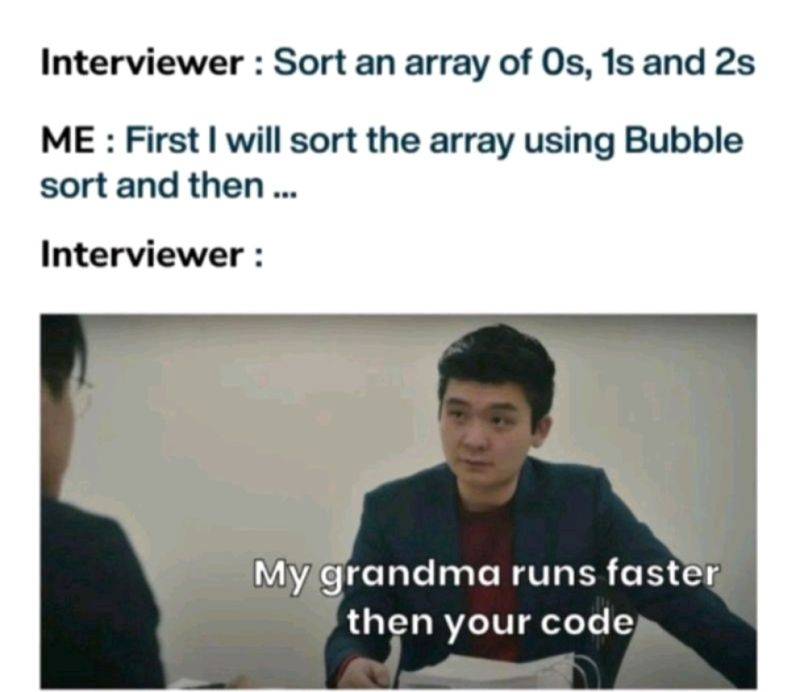

#  4 Online Learning

### 4.1 Concept of online learning

The essence of online learning is that the data comes in sequentially, and we improve the model after each new example

This is useful in two cases:

1) the sample does not fit in memory
2) you need to quickly adapt to new data dependencies

The second case is relevant, for example, for algorithmic trading, when you need to quickly adapt to certain stock market changes. The first case is the classical problem of Big Data. There are many possible definitions of what Big Data is. On an intuitive level, this is when we either have too many observations or too many features. Thus, our dataset is either very wide or very long. If it is very long, this problem is very easily solved with the help of online learning, which we will do a bit later

### 4.2 Linear Regression case

Suppose we have n obervations: $Y = (y_1, y_2, ..., y_n)$ and d features. Matrix $X$ shows us features for all observations, so $X \in R^{n x d}$. If we try to approximate $Y$ linearly, we will get a system of equations of a kind:

$$y_i = w_0x_{i0} + ... + w_dx_{id} \Rightarrow y_i = <w, x_i>$$

And it turns out that we can find the solution explicitly:

$$w^* = (X^TX)^{-1}X^TY$$

Now, when we have repeated the first page of the first chapter of the first book of Machine Learning, we can think of some issues with this approach. At first, we need to invert a matrix, which is a cubic, thus, very costly algorithm. That is why numerical methods, such as Gradient Descent, are preferred here. However, we still need to store the whole dataset in memory, if we speak about Vanilla Gradient Descent. In case of Stochastic Gradient Descent (SGD), we use just one observation at a time. The great thing about it is not only that we make algorithm n times faster, but also that now we can just read dataset line by line to update weights. This will be our iterations and it works fine. So, now we can update weights recursively, using a standard formula SGD weight update:

$$w_i = w_{i-1} - \gamma_ix_i(x^T_iw_{i-1} - y_i)$$

This is one way we can solve the problem. However, there were already invented advanced open-source tools, and we will consider one of them

### 4.3 Vowpal Wabbit (VW)

(https://vowpalwabbit.org)

This is a popular tool to train linear models online in an efficient way. There are many cool things about it:

1) It has many loss functions

2) We can use feature interactions (for example, double and triple featrure combinations)

3) It does feature hashing automatically. We will see later that we can use even text features without preprocessing, as well as combinations of categorical features

4) Efficient scaling (in fact, VW was designed for this)

We will use this interactive Machine Learning library to solve the problem

# 5 Model training and making predicitons

### 5.1 Format

Both train and test datasets must match the desired format. It is specific but we cannot do anything about it. In a nutshell, you first specify the target, and after that you specify features, separating them with | symbol. Each feature should be named with an arbitrary symbol. According to VW documentation https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/cmd_linear_regression.html#create-a-dataset, one separator is enough (just to separate features from the target), but I am used to doing like I am doing here. Now we will write a special function that will help us make an input training file from our dataset

In [8]:
def convert_to_vw(data):
    target = 1 if data['clicked'] == '1' else -1
    
    ad_id = data['ad_id']
    promo_document_id = data['promo_document_id']
    campaign_id = data['campaign_id']
    advertiser_id = data['advertiser_id']
    
    document_id = data['document_id']
    platform = data['platform']
    country = data['country']
    state = data['state']
    dma = data['dma']
    docs_for_user = data['docs_for_user']
    
    
    template = "{target} |a {ad_id} |p {promo_document_id} |c {campaign_id} |b {advertiser_id} |d {document_id} |e {platform} |r {country} |s {state} |f {dma} |u {docs_for_user}"
    return template.format(
        target=target,
        ad_id=ad_id,
        promo_document_id=promo_document_id,
        campaign_id=campaign_id,
        advertiser_id=advertiser_id,
        document_id=document_id,
        platform=platform,
        country=country,
        state=state,
        dma=dma,
        docs_for_user = docs_for_user
    )

### 5.2 Now let's convert our dataset into needed format

In [9]:
dataset2.rdd.map(convert_to_vw).saveAsTextFile('/user/Clicks_prediction/train_new_docs.vw')

In [9]:
! hdfs dfs -cat /user/Clicks_prediction/train_new_docs.vw/* > train_exp.vw

### 5.3 Time to train the model

We will use ftrl with parameters, as advised in the mentioned report. The very basic description can be found in that report, but for more information one can check https://courses.cs.washington.edu/courses/cse599s/12sp/scribes/Lecture8.pdf. In addition, we will also use pairwise combinations of several features. The report advised taking specific features for interactions, I basically did so, but added interactions of all these features with our new feature from page_views. Notice that I do not do feature hashing, and VW works perfectly fine while creating feature combinations. In fact, this weird feature from page_views improves the score by around 2%, although it would be very complicated to work with it if we used a common Linear Regression or Gradient Boosting (CatBoost, for example)

In [10]:
! vw --final_regressor clicks.model.bin train_exp.vw \
--bit_precision 23 \
--ftrl \
--ftrl_alpha 0.05 \
--ftrl_beta 0.5 --l1 10 \
--interactions pc pb pd pe pr ps cb cd ce cr cs bd be br bs de dr ds er es rs up uc ub ud ue ur us \
--cache -k \
--loss_function logistic

creating features for following interactions: pc pb pd pe pr ps cb cd ce cr cs bd be br bs de dr ds er es rs up uc ub ud ue ur us 
using l1 regularization = 10
final_regressor = drugs.model.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
creating cache_file = train_exp.vw.cache
Reading datafile = train_exp.vw
num sources = 1
Enabled reductions: ftrl, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       55
0.693147 0.693147            2            2.0   1.0000   0.0000       55
0.693147 0.693147            4            4.0  -1.0000   0.0000       55
0.693147 0.693147            8            8.0  -1.0000   0.0000      119
0.693147 0.693147           16           16.0   1.0000   0.0000      119
0.78995

### 5.4 Model is trained. Now we will convert test dataset in the required format

The only difference is that now we will not specify the tarhet, since we do not have it

In [11]:
def convert_to_vw_submission(data):
    
    display_id = data['display_id']
    ad_id = data['ad_id']
    promo_document_id = data['promo_document_id']
    campaign_id = data['campaign_id']
    advertiser_id = data['advertiser_id']
    
    document_id = data['document_id']
    platform = data['platform']
    country = data['country']
    state = data['state']
    dma = data['dma']
    docs_for_user = data['docs_for_user']
    
    
    template = "|{display_id} |a {ad_id} |p {promo_document_id} |c {campaign_id} |b {advertiser_id} |d {document_id} |e {platform} |r {country} |s {state} |f {dma} |u {docs_for_user}"
    return template.format(
        display_id = display_id,
        ad_id=ad_id,
        promo_document_id=promo_document_id,
        campaign_id=campaign_id,
        advertiser_id=advertiser_id,
        document_id=document_id,
        platform=platform,
        country=country,
        state=state,
        dma=dma,
        docs_for_user = docs_for_user
    )

In [14]:
dataset22.rdd.map(convert_to_vw_submission).saveAsTextFile('/user/Clicks_prediction/test_new_docs.vw')

In [11]:
! hdfs dfs -cat /user/Clicks_prediction/test_new_docs.vw/* > test_for_submission_exp.vw

### 5.5 Make predictions and put them in a special txt file

In [12]:
%%time

! vw test_for_submission_exp.vw \
    --link=logistic \
    --testonly \
    --initial_regressor clicks.model.bin \
    --predictions for_submission.txt

creating features for following interactions: pc pb pd pe pr ps cb cd ce cr cs bd be br bs de dr ds er es rs up uc ub ud ue ur us 
only testing
predictions = for_submission.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test_for_submission_exp.vw
num sources = 1
Enabled reductions: ftrl, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.1453       39
    n.a.     n.a.            2            2.0  unknown   0.0400       39
    n.a.     n.a.            4            4.0  unknown   0.1176       39
    n.a.     n.a.            8            8.0  unknown   0.1492       63
    n.a.     n.a.           16           16.0  unknown   0.0810       39
    n.a.     n.a.           32     

In [13]:
! head for_submission.txt

0.145332
0.040023
0.053138
0.117615
0.286139
0.082552
0.232670
0.149204
0.257443
0.183910


# 6 Submission

All we have to do now is convert our predictions to the right format, so it looks like the sample submission table. I will first take the keys from the test, then connect them with the predictions, and after that I will make it look just as it needs to

### 6.1 The first step

In [15]:
! hdfs dfs -put for_submission.txt /user/Clicks_prediction/for_submission_bdz1.txt

In [16]:
dataset23 = dataset22.select('display_id', 'ad_id')

In [17]:
dataset23.show(1)

+----------+------+
|display_id| ad_id|
+----------+------+
|  22230846|186412|
+----------+------+
only showing top 1 row



In [19]:
dataset23.write.csv("/user/Clicks_prediction/to_concat_bdz1.csv")

In [20]:
! hdfs dfs -cat '/user/Clicks_prediction/for_submission_bdz1.txt' > for_submission_bdz1.txt
! hdfs dfs -cat '/user/Clicks_prediction/to_concat_bdz1.csv/*' > to_concat_bdz1.csv

In [21]:
df1 = pd.read_csv('to_concat_bdz1.csv', header = None)
df1.columns = ['display_id', 'ad_id']

df = pd.read_csv('for_submission_bdz1.txt', header = None)
df.columns = ['proba']

df2 = pd.concat([df1, df], axis = 1)

In [22]:
df2.to_csv('submission_table_bdz1.csv')

In [24]:
! hdfs dfs -put submission_table_bdz1.csv '/user/Clicks_prediction/submission_table_bdz1.csv'

In [25]:
submission_table = se.read.csv("/user/Clicks_prediction/submission_table_bdz1.csv", sep=r',', header=True)

In [26]:
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import *
from pyspark.sql.types import StringType

### 6.2 Right order
For each display_id, we sort the probabilities in descending order so that the order is correct for sending. Then we use the smart collect_list function. After that, it remains just to convert it into a text format. To do this, we remove the commas, and then cut out the first and last elements from the text (these are brackets that open and close the list)

In [27]:
submission_table1 = submission_table.orderBy(['display_id', 'proba'], ascending=False) \
.groupBy("display_id").agg(collect_list("ad_id") \
.alias("ad_id")).withColumn("ad_id", col("ad_id").cast(StringType()))
submission_table1 = submission_table1.withColumn('ad_id', regexp_replace('ad_id', ',', ''))
submission_table1 = submission_table1.withColumn("ad_id", expr("substring(ad_id, 2, length(ad_id))"))
submission_table1 = submission_table1.withColumn("ad_id", expr("substring(ad_id, 1, (length(ad_id) - 1))"))

### 6.3 Write the file and submit it to Kaggle

In [29]:
submission_table1.write.csv("/user/Clicks_prediction/almost_there_bdz1.csv")

In [30]:
! hdfs dfs -cat '/user/Clicks_prediction/almost_there_bdz1.csv/*' > for_kaggle_bdz1.csv

In [31]:
! sed -i '1idisplay_id,ad_id' for_kaggle_bdz1.csv

In [32]:
! head for_kaggle_bdz1.csv

display_id,ad_id
16874673,91797 207162 107055 158923
16874705,141374 140897 237858
16874826,124583 124591 81645 81656 60620
16875215,67862 212145 252058 44141 173402 269017
16875344,141009 69098 123093 151955 288314 173006
16875431,190086 195273 69823 108393
16875591,303990 82377 39897 59304
16875854,40717 242759 186789 326617 237442
16876193,172434 23288 129490 238212 42115 180693


In [33]:
! kaggle competitions submit -c outbrain-click-prediction -f for_kaggle_bdz1.csv -m "submission_bdz1"

100%|████████████████████████████████████████| 260M/260M [00:08<00:00, 31.5MB/s]
Successfully submitted to Outbrain Click Prediction

### 6.4 The metric we got

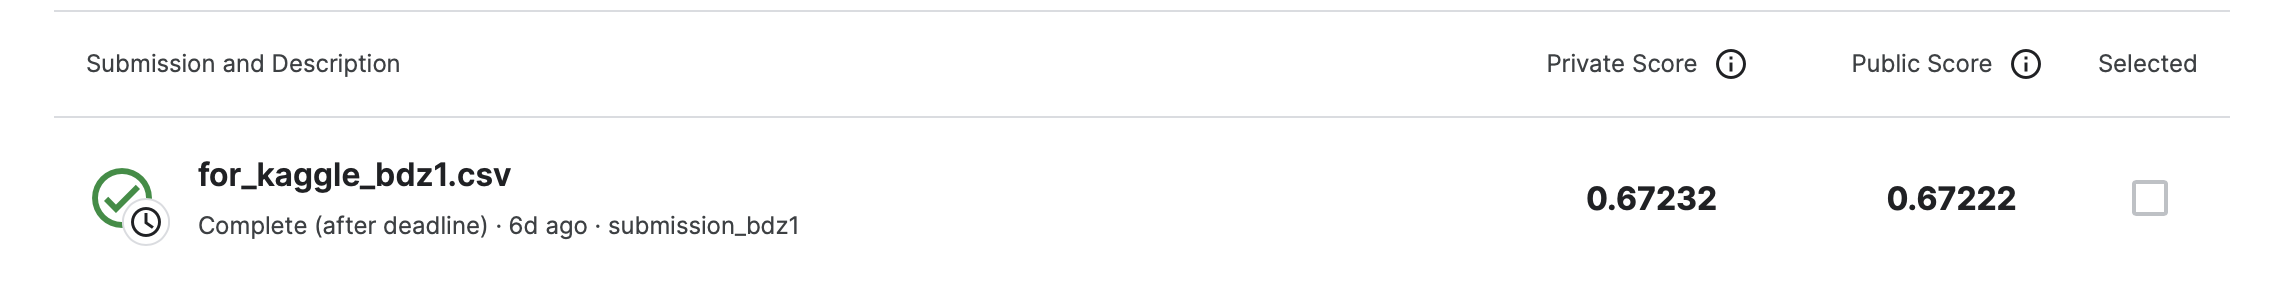

~ 0.68 is around 50 place on leaderboard. If we applied the leakage, we would get just slightly less. Of course, the competition is old and probably people solving it did not have such tools as we have now, but the result is still satisfying

# 7 References



1) http://dsnotes.com/post/2017-01-27-lessons-learned-from-outbrain-click-prediction-kaggle-competition/ - insights from one of the top-scorers

2) https://towardsdatascience.com/6-recommendations-for-optimizing-a-spark-job-5899ec269b4b - some useful things about Spark Optimization

3) https://github.com/ZEMUSHKA/lsml_hse_lectures/blob/master/3_LinearModels.pdf - some useful theory about online learning and VW

4) https://github.com/ADKosm/lsml-2023-public/blob/main/06.%20Classical%20models.%20Wide%20data.ipynb - working with Big Data and training VW on Python

5) https://github.com/ADKosm/lsml-2023-public/blob/main/07.%20Distributed%20training.ipynb - more about VW, how we can use it, and how to install it

6) https://vowpalwabbit.org/, https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/cmd_linear_regression.html#create-a-dataset - official documentation of VW, if one wants to know more about it

7) https://courses.cs.washington.edu/courses/cse599s/12sp/scribes/Lecture8.pdf - about ftrl

8) https://www.youtube.com/watch?v=dQw4w9WgXcQ - just check it :)